# 55(row)x100(col)x750(height) Model Run using CFP 2019 Excecuatble

## 1.0. Setup

### 1.0.1. Imports

In [1]:
import os
import numpy as np
import numpy.ma as ma
import csv                                             
import flopy
import flopy.utils.binaryfile as bf
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

### 1.0.2. Directory 

In [2]:
# change active directory to model directory
path =""
if not os.path.exists(path):
    nb_dir = os.getcwd()
    path = os.path.join(nb_dir, "Porous_Media_Model")
    if not os.path.exists(path):
        os.makedirs(path)

## 1.1. Model Setup

### 1.1.1. Model Variables and ___

In [3]:
""" define model object """
os.chdir(path)
modelname = "base"
# using the CFPv2 here, which does support CADS
# to change, type in the correct CFP version for exe_name
# mf = flopy.modflow.Modflow(modelname, exe_name="CFPv2")

In [4]:
##Name:
modelname = "base"

##Grid:
n_rows = 55          #number of rows
n_cols = 100          #number of columns
delr = 10.       #width of each cell along rows (so really this is column width along x axis)
delc = 10.       #width of each cell along columns (so really this is row height along y axis)
Lx = n_cols*delr     #width of domain in x (across columns) = number of columns x cell width
Ly = n_rows*delc     #width of domain in y (across rows) = number of rows x cell height

##Layers:
n_lays = 1                                                #number of layers
layers = np.arange(n_lays)                                #make array of layers
ztop = np.ones((n_rows,n_cols)) * 750   #import top elevation of model from csv file (dim: n_rows,n_cols)
zbot = 0.                                               #bottom elevation of model (datum)
botm = np.full((n_lays,n_rows,n_cols),zbot)                   #make array of default cell bottom elevations for each cell in the model (dim:n_lays,n_rows,n_cols)


##Medium properties:
#Hydraulic conductivity:
#Kx and Ky:
K_horiz = 20.    #horizontal hydraulic conductivity (along rows)
K_ratio = 1.     #ratio of Ky/Kx (aka Kcol/Krow) - if Kx=Ky, ratio=1
#Kz:
K_vert = 20.     #vertical hydraulic conductivity (along z axis)

#Porosity, storage, specific yield, confined/unconfined:
n  = 0.1         #porosity
Ss = 0.0001      #specific storage
Sy = 0.1         #specific yield
uncnf = 1        #if 0 then confined, if >0 then unconfined

## 1.2. Modflow Setup

In [5]:
##Constant head boundary conditions:
#if ibound < 0, constant head; if ibound = 0, inactive/no-flow/outside of watershed; if ibound > 0, active.

#create arrays to indicate active cells and boundary conditions (ibound):
ibound = np.full((n_lays,n_rows,n_cols),1)                            #make array of zeros for default boundary conditions (dim:n_lays,n_rows,n_cols)  #import locations of active and inactive cells from csv (all layers, all rows, all cols)
ibound[:,:,n_cols-1] = -1 #replace rightmost (eastern) column (slice all layers, active rows, last column) with -1 to indicate constant head
ibound[:,:,0] = -1 #set first row to constant head?

# ibound[:,0,:]
# ibound[:,]
#create array of initial head values across the model and at the boundaries
H_init =690.                                #initial hydraulic head in meters
strt = np.full((n_lays, n_rows, n_cols), H_init)  #float (i.e. decimal) array, sets initial head in all cells to desired value
strt[:,:,0] = 700
strt[:,:,n_cols-1] = 690

In [6]:
## Recharge conditions:
R = 0                              #recharge rate [m/day]
rech = np.zeros((n_rows,n_cols))          #make array of zeros for recharge (dim: n_rows, n_cols, no layers because recharge only happens in top layer)
rech[:,:] = R                      #set recharge in the leftmost 15 columns to the desired recharge rate


In [7]:
##Outputs:
#this section usually does not change - we are telling the model which outputs to print

oc_spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...']
ipakcb = 53    #unit to save cell-by-cell outputs to

### 1.3 Write Inputs to Model and Run

### 1.3.1 Update .nam file 

In [8]:


#Create the model objects and the objects for each package
#Note: running this section multiple times without changing filenames (see block above) will overwrite the existing 
#files & generate a warning that existing packages are being replaced. This is fine.

#Create model object:
mf = flopy.modflow.Modflow(modelname, exe_name='CFPv2')    #MODFLOW executable must be in same folder, named mf2005.exe
    
#Create objects for each package (see GHW1 notebook for details):
dis = flopy.modflow.ModflowDis(mf, n_lays, n_rows, n_cols, delr=delr, 
                               delc=delc, top=ztop, botm=botm, steady=True)         #DIS (Discretization): creates model grid   
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)           #BAS (Basic): assigns head boundaries
lpf = flopy.modflow.ModflowLpf(mf, laytyp=uncnf, chani=0, hk=K_horiz, hani=K_ratio, vka=K_vert, 
        ss=Ss, sy=Sy, storagecoefficient=False, ipakcb=ipakcb)            #LPF (Layer Property Flow): assigns flow props between cells
oc = flopy.modflow.ModflowOc(mf, stress_period_data=oc_spd, compact=True) #OC (Output Control): Decides what outputs to save
pcg = flopy.modflow.ModflowPcg(mf)                                        #PCG (Preconditioned Conjugate Gradient)
rch = flopy.modflow.mfrch.ModflowRch(mf, rech=rech)              

Model Input

Text(0, 0.5, 'y [m]')

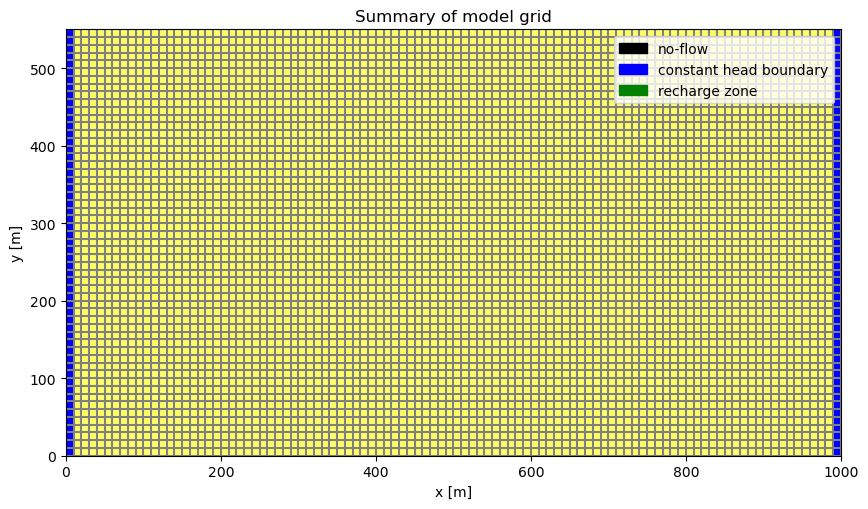

In [9]:
#Plot model boundary conditions summary:
f,ax = plt.subplots(1,1,figsize=(10,10))                    #create new figure and axes
plt.title('Summary of model grid')                          #set figure title
m = flopy.plot.PlotMapView(model=mf, layer=0)               #create model map object
grid = m.plot_grid(colors='gray')                           #plot model grid
r = m.plot_array(rech, cmap='summer_r')                                              #plot recharge array
bc = m.plot_ibound()                       #plot boundary conditions

#Format and legend
plt.legend(handles=[matplotlib.patches.Patch(color='black',label='no-flow'),      #add legend manually
                    matplotlib.patches.Patch(color='blue',label='constant head boundary'),
                    matplotlib.patches.Patch(color='green',label='recharge zone')])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

In [10]:
#Write MODFLOW input files:
mf.write_input()

#Run MODFLOW:
success, buff = mf.run_model()                 #you should see "normal termination of simulation" printed below

FloPy is using the following  executable to run the model: .\CFPv2.EXE

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                   Version 1.9.62 2019/09/16 CFPv2 HTM/STM/UMT-LNK/CADS
THIS IS A RESEARCH VERSION OF CFP MODE 1 FOR TEST PURPOSES WITHOUT ANY WARRANTY REGARDING CORRECTNESS
CONTACT: THOMAS.REIMANN@TU-DRESDEN.DE AND BSHOEMAK@USGS.GOV

 Using NAME file: base.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/03/08 13:04:27

 CFP FLOW STRESS PERIOD:     1 TIME STEP:     1
 RUN END DATE AND TIME (YYYY/MM/DD HH:MM:SS): 2024/03/08 13:04:27
 ELAPSED RUN TIME:  0.126 SECONDS

  NORMAL TERMINATION OF SIMULATION


## Output

In [11]:
##Get outputs:
#This section usually does not change much

#Get MODFLOW outputs:
hds = bf.HeadFile(modelname+'.hds')    #reads the raw binary head output file 
times = hds.get_times()                #returns a list of timesteps
head = hds.get_data(totim=times[-1])   #returns an array of heads for the specified time (last timestep)
head_mx = ma.masked_values (head, -999.99)  #make a masked head array where all no-flow cells (with the value -999.99) are hidden

#Get cell-by-cell outputs from the cell budget output file:
#string options are in the list file under output control (make sure to include spaces!)
cbb = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
kstpkper_list = cbb.get_kstpkper()          #returns a list of stress periods & timesteps
frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]      #returns an array of flow rates for right face of cells
fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]      #returns an array of flow rates for front face of cells

In [12]:
#Display water budget:

#Get water budget information:
lst = flopy.utils.MfListBudget(modelname+'.list')       #read the list file
budget = lst.get_data()                                 #get cumulative water budget for last timestep
labels = [str(budget[i][2])[2:] for i in np.arange(len(budget))] #get and trim labels for each budget item (one-line for loop)
vals = [budget[i][1] for i in np.arange(len(budget))]   #get values for each budget item

#Print water budget:
print('%25s'%'MASS BALANCE','\n')   #print right-justified header taking up 25 spaces, then go to new line
b=[print("%25s"%labels[i],'\t',"%10s"%vals[i]) for i in np.arange(len(budget))]  #iterate to print each item in buget

#Print timesteps:
print('\ntimesteps:',times)
print('stress periods:', kstpkper_list)

             MASS BALANCE 

              STORAGE_IN' 	        0.0
        CONSTANT_HEAD_IN' 	   77222.22
             RECHARGE_IN' 	        0.0
                TOTAL_IN' 	   77222.22
             STORAGE_OUT' 	       -0.0
       CONSTANT_HEAD_OUT' 	  -77222.22
            RECHARGE_OUT' 	       -0.0
               TOTAL_OUT' 	  -77222.22
                  IN-OUT' 	 7.2723e-07
     PERCENT_DISCREPANCY' 	        0.0

timesteps: [1.0]
stress periods: [(0, 0)]


In [13]:
#Get hydraulic head at a specific location (the head you would measure if you installed a piezometer there):

# lay = 0                     #layer piezometer is in
# row = 12                    #row piezometer is in
# col = 42                    #column piezometer is in
# h = head[lay,row,col]       #head at piezometer location

# piezo = np.full((n_lays,n_rows,n_cols), np.nan)  #create array of null values to be able to map piezometer
# piezo[lay,row,col] = 1                     #mark the piezometer location with a 1

vmin = head_mx.min()                      #find the lowest head in entire model (excluding no-flow cells)
vmax = head_mx.max()                      #find the highest head in entire model (excluding no-flow cells)

# text = 'Head at layer {}, row {}, col {}: \t{:.3f} m'   #text to print (print last one with only 3 decimal places, add a tab before the last item)
# print(text.format(lay,row,col,h))  #print and fill curly brackets above with parameter values

# text = 'Min. head anywhere in model: \t\t{} m \nMax. head anywhere in model: \t\t{:.3f} m'
# print(text.format(vmin,vmax))

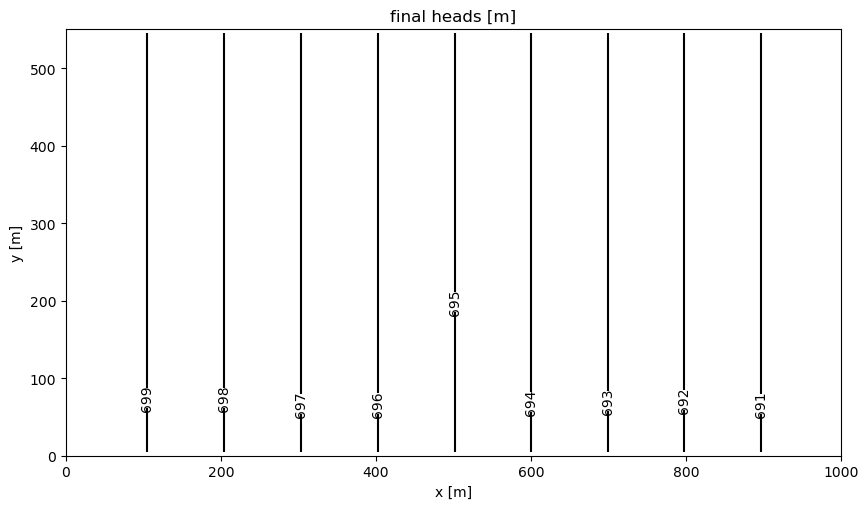

In [14]:
#Plot the hydraulic heads in layer 1 at the end of the model run

f,ax = plt.subplots(1,1, figsize=(10,10))         #create figure and axis objects
ax.set_title('final heads [m]')                   #set figure title

maps = flopy.plot.PlotMapView(model=mf)           #create flopy map object
# h = maps.plot_array(head[0,:,:], masked_values=[-999.99], cmap='binary')  #plot heads as grayscale map
levels = np.arange(head_mx.min(), head_mx.max(), 1)                       #set contour range and interval
c = maps.contour_array(head[0,:,:], masked_values=[-999.99], levels=levels, colors = 'k') #plot head contours
plt.clabel(c, rightside_up=False)   #add contour labels, not oriented for reading but for contour direction 

#Add legend and axis labels

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

#Add colorbar:
divider = make_axes_locatable(ax)                         #make axes dividable (to add colorbar)
# cax = divider.append_axes('bottom

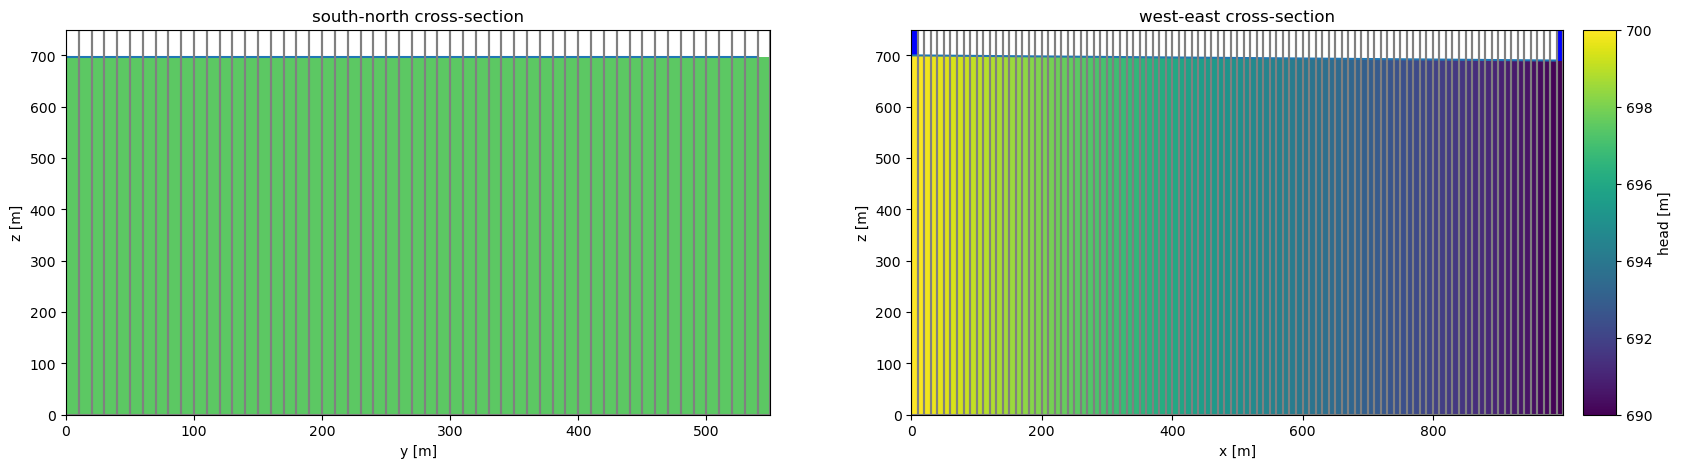

In [15]:
#Plot cross-section view of heads at center row and column:

f,ax = plt.subplots(1,2, figsize=(20,5))                                     #create empty figure and axes objects
xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[0], line={'Column': 25})  #plot cross-section along given column (change column # to see different locations)
bc = xsec.plot_ibound()                                                      #plot boundary conditions
h  = xsec.plot_array(head, masked_values=[-999.99], head=head, vmin=vmin, vmax=vmax)  #plot heads as an array, with color range set by min and max of full array
ax[0].plot(np.arange(0,Ly,delr), head_mx[0,:,25])                            #plots heads as a line
g  = xsec.plot_grid()                                                        #plot model grid
ax[0].set_xlabel('y [m]')
ax[0].set_ylabel('z [m]')
ax[0].set_title('south-north cross-section')

xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[1], line={'Row': 25})      #plot cross-ection along given row
bc = xsec.plot_ibound()                                                      #plot boundary conditions
h  = xsec.plot_array(head, masked_values=[-999.99], head=head, vmin=vmin, vmax=vmax)   #plot heads as array with same color range as above
ax[1].plot(np.arange(0,Lx,delc), head_mx[0,25,:])                            #plots heads as a line
g  = xsec.plot_grid()                                                        #plot grid
ax[1].set_xlabel('x [m]')
ax[1].set_ylabel('z [m]')
ax[1].set_title('west-east cross-section')

#Add colorbar:
divider = make_axes_locatable(ax[1])                     #make axes dividable (to add colorbar)
cax = divider.append_axes('right', size="5%", pad=0.2)   #add an axis at the bottom for the colorbar
c = plt.colorbar(h, cax=cax, orientation='vertical')     #plot the colorbar
c.set_label('head [m]')                                  #label the colorbar

## Head Vartest

In [16]:
vartest = True

In [17]:
if vartest == True:
    H_init =690.                                #initial hydraulic head in meters
    strt = np.full((n_lays, n_rows, n_cols), H_init)  #float (i.e. decimal) array, sets initial head in all cells to desired value
    strt[:,:,0] = 700
    strt[:,:,n_cols-1] = 600
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt) 
    mf.write_input()
    success, buff = mf.run_model()

FloPy is using the following  executable to run the model: .\CFPv2.EXE

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                   Version 1.9.62 2019/09/16 CFPv2 HTM/STM/UMT-LNK/CADS
THIS IS A RESEARCH VERSION OF CFP MODE 1 FOR TEST PURPOSES WITHOUT ANY WARRANTY REGARDING CORRECTNESS
CONTACT: THOMAS.REIMANN@TU-DRESDEN.DE AND BSHOEMAK@USGS.GOV

 Using NAME file: base.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/03/08 13:04:28

 CFP FLOW STRESS PERIOD:     1 TIME STEP:     1
 RUN END DATE AND TIME (YYYY/MM/DD HH:MM:SS): 2024/03/08 13:04:28
 ELAPSED RUN TIME:  0.138 SECONDS

  NORMAL TERMINATION OF SIMULATION


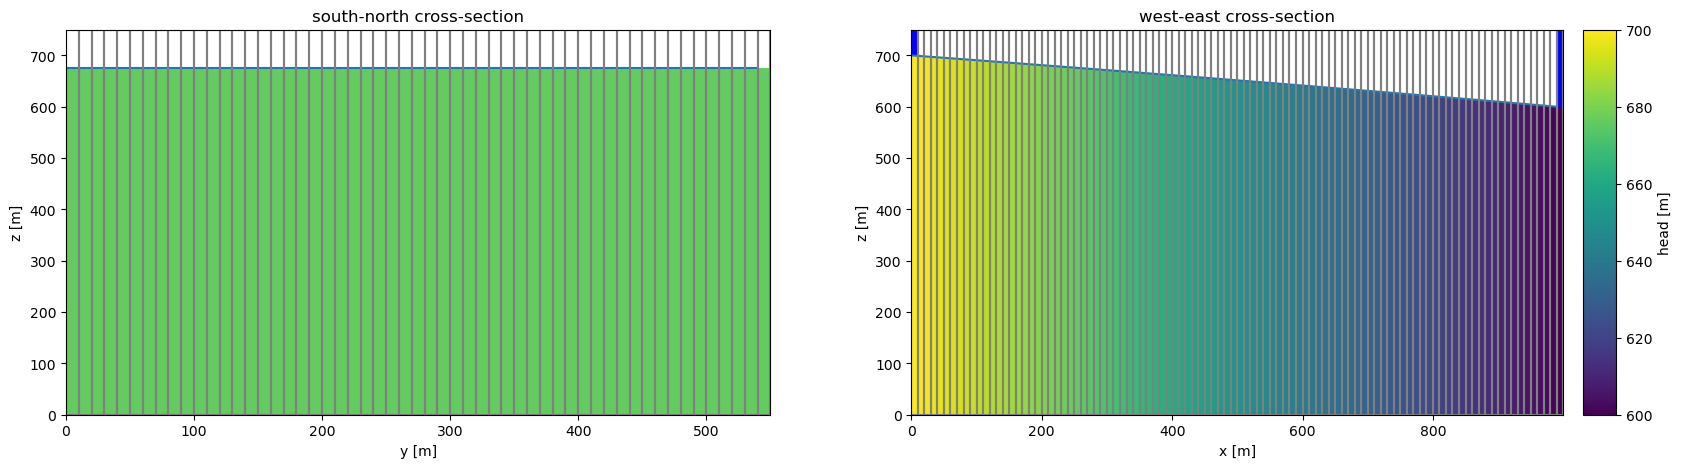

In [18]:
if vartest == True:

    ##Get outputs:
    #This section usually does not change much
    
    #Get MODFLOW outputs:
    hds = bf.HeadFile(modelname+'.hds')    #reads the raw binary head output file 
    times = hds.get_times()                #returns a list of timesteps
    head = hds.get_data(totim=times[-1])   #returns an array of heads for the specified time (last timestep)
    head_mx = ma.masked_values (head, -999.99)  #make a masked head array where all no-flow cells (with the value -999.99) are hidden
    
    #Get cell-by-cell outputs from the cell budget output file:
    #string options are in the list file under output control (make sure to include spaces!)
    cbb = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
    kstpkper_list = cbb.get_kstpkper()          #returns a list of stress periods & timesteps
    frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]      #returns an array of flow rates for right face of cells
    fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]      #returns an array of flow rates for front face of cells


    vmin = head_mx.min()                      #find the lowest head in entire model (excluding no-flow cells)
    vmax = head_mx.max()      
    
    f,ax = plt.subplots(1,2, figsize=(20,5))                                     #create empty figure and axes objects
    xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[0], line={'Column': 25})  #plot cross-section along given column (change column # to see different locations)
    bc = xsec.plot_ibound()                                                      #plot boundary conditions
    h  = xsec.plot_array(head, masked_values=[-999.99], head=head, vmin=vmin, vmax=vmax)  #plot heads as an array, with color range set by min and max of full array
    ax[0].plot(np.arange(0,Ly,delr), head_mx[0,:,25])                            #plots heads as a line
    g  = xsec.plot_grid()                                                        #plot model grid
    ax[0].set_xlabel('y [m]')
    ax[0].set_ylabel('z [m]')
    ax[0].set_title('south-north cross-section')
    
    xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[1], line={'Row': 25})      #plot cross-ection along given row
    bc = xsec.plot_ibound()                                                      #plot boundary conditions
    h  = xsec.plot_array(head, masked_values=[-999.99], head=head, vmin=vmin, vmax=vmax)   #plot heads as array with same color range as above
    ax[1].plot(np.arange(0,Lx,delc), head_mx[0,25,:])                            #plots heads as a line
    g  = xsec.plot_grid()                                                        #plot grid
    ax[1].set_xlabel('x [m]')
    ax[1].set_ylabel('z [m]')
    ax[1].set_title('west-east cross-section')

    
    
    #Add colorbar:
    divider = make_axes_locatable(ax[1])                     #make axes dividable (to add colorbar)
    cax = divider.append_axes('right', size="5%", pad=0.2)   #add an axis at the bottom for the colorbar
    c = plt.colorbar(h, cax=cax, orientation='vertical')     #plot the colorbar
    c.set_label('head [m]')

In [19]:
if vartest == True:
    H_init =690.                                #initial hydraulic head in meters
    strt = np.full((n_lays, n_rows, n_cols), H_init)  #float (i.e. decimal) array, sets initial head in all cells to desired value
    strt[:,:,0] = 700
    strt[:,:,n_cols-1] = 500
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt) 
    mf.write_input()
    success, buff = mf.run_model()

FloPy is using the following  executable to run the model: .\CFPv2.EXE

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                   Version 1.9.62 2019/09/16 CFPv2 HTM/STM/UMT-LNK/CADS
THIS IS A RESEARCH VERSION OF CFP MODE 1 FOR TEST PURPOSES WITHOUT ANY WARRANTY REGARDING CORRECTNESS
CONTACT: THOMAS.REIMANN@TU-DRESDEN.DE AND BSHOEMAK@USGS.GOV

 Using NAME file: base.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/03/08 13:04:28

 CFP FLOW STRESS PERIOD:     1 TIME STEP:     1
 RUN END DATE AND TIME (YYYY/MM/DD HH:MM:SS): 2024/03/08 13:04:29
 ELAPSED RUN TIME:  0.200 SECONDS

  NORMAL TERMINATION OF SIMULATION


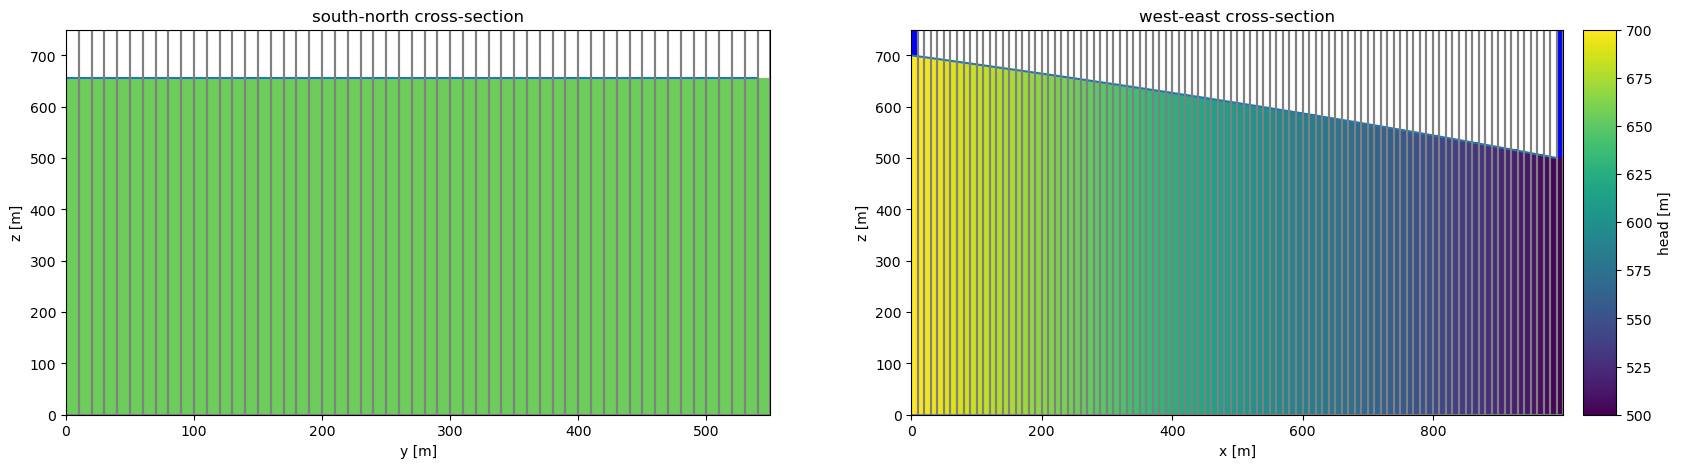

In [20]:
if vartest == True:

    ##Get outputs:
    #This section usually does not change much
    
    #Get MODFLOW outputs:
    hds = bf.HeadFile(modelname+'.hds')    #reads the raw binary head output file 
    times = hds.get_times()                #returns a list of timesteps
    head = hds.get_data(totim=times[-1])   #returns an array of heads for the specified time (last timestep)
    head_mx = ma.masked_values (head, -999.99)  #make a masked head array where all no-flow cells (with the value -999.99) are hidden
    
    #Get cell-by-cell outputs from the cell budget output file:
    #string options are in the list file under output control (make sure to include spaces!)
    cbb = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
    kstpkper_list = cbb.get_kstpkper()          #returns a list of stress periods & timesteps
    frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]      #returns an array of flow rates for right face of cells
    fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]      #returns an array of flow rates for front face of cells

    vmin = head_mx.min()                      #find the lowest head in entire model (excluding no-flow cells)
    vmax = head_mx.max()      
    
    f,ax = plt.subplots(1,2, figsize=(20,5))                                     #create empty figure and axes objects
    xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[0], line={'Column': 25})  #plot cross-section along given column (change column # to see different locations)
    bc = xsec.plot_ibound()                                                      #plot boundary conditions
    h  = xsec.plot_array(head, masked_values=[-999.99], head=head, vmin=vmin, vmax=vmax)  #plot heads as an array, with color range set by min and max of full array
    ax[0].plot(np.arange(0,Ly,delr), head_mx[0,:,25])                            #plots heads as a line
    g  = xsec.plot_grid()                                                        #plot model grid
    ax[0].set_xlabel('y [m]')
    ax[0].set_ylabel('z [m]')
    ax[0].set_title('south-north cross-section')
    
    xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[1], line={'Row': 25})      #plot cross-ection along given row
    bc = xsec.plot_ibound()                                                      #plot boundary conditions
    h  = xsec.plot_array(head, masked_values=[-999.99], head=head, vmin=vmin, vmax=vmax)   #plot heads as array with same color range as above
    ax[1].plot(np.arange(0,Lx,delc), head_mx[0,25,:])                            #plots heads as a line
    g  = xsec.plot_grid()                                                        #plot grid
    ax[1].set_xlabel('x [m]')
    ax[1].set_ylabel('z [m]')
    ax[1].set_title('west-east cross-section')
    
    #Add colorbar:
    divider = make_axes_locatable(ax[1])                     #make axes dividable (to add colorbar)
    cax = divider.append_axes('right', size="5%", pad=0.2)   #add an axis at the bottom for the colorbar
    c = plt.colorbar(h, cax=cax, orientation='vertical')     #plot the colorbar
    c.set_label('head [m]')

In [21]:
if vartest == True:
    H_init = 690.                                #initial hydraulic head in meters
    strt = np.full((n_lays, n_rows, n_cols), H_init)  #float (i.e. decimal) array, sets initial head in all cells to desired value
    strt[:,:,0] = 700
    strt[:,:,n_cols-1] = 400
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt) 
    mf.write_input()
    success, buff = mf.run_model()

FloPy is using the following  executable to run the model: .\CFPv2.EXE

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                   Version 1.9.62 2019/09/16 CFPv2 HTM/STM/UMT-LNK/CADS
THIS IS A RESEARCH VERSION OF CFP MODE 1 FOR TEST PURPOSES WITHOUT ANY WARRANTY REGARDING CORRECTNESS
CONTACT: THOMAS.REIMANN@TU-DRESDEN.DE AND BSHOEMAK@USGS.GOV

 Using NAME file: base.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/03/08 13:04:29

 CFP FLOW STRESS PERIOD:     1 TIME STEP:     1
 RUN END DATE AND TIME (YYYY/MM/DD HH:MM:SS): 2024/03/08 13:04:29
 ELAPSED RUN TIME:  0.226 SECONDS

  NORMAL TERMINATION OF SIMULATION


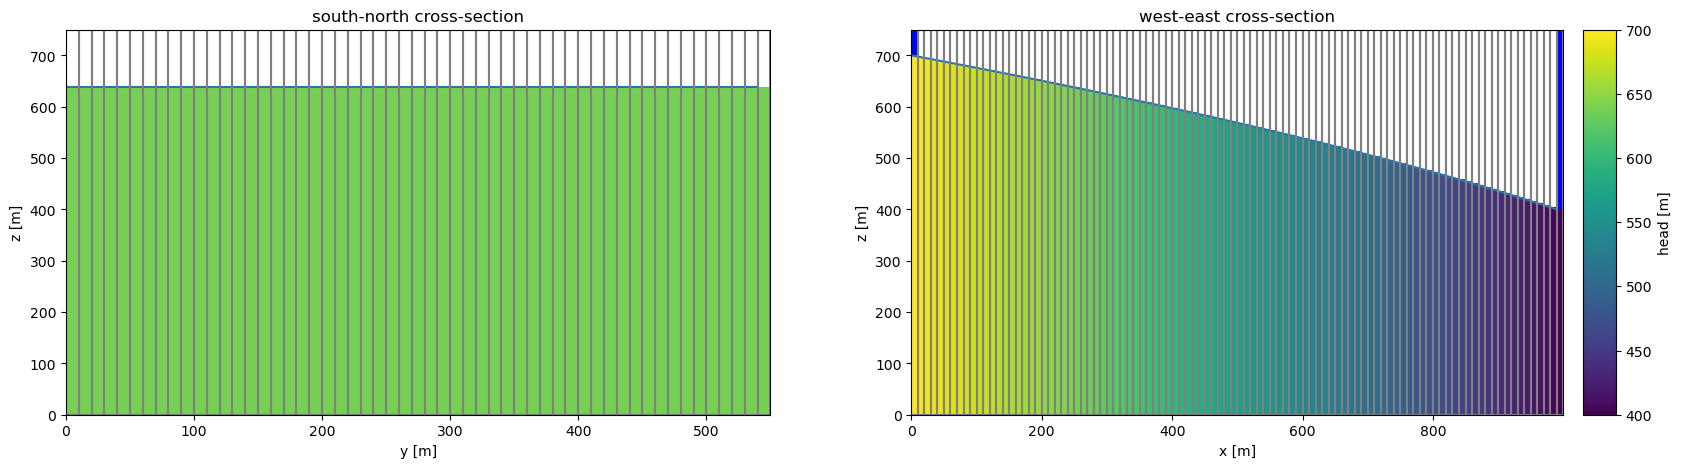

In [22]:
if vartest == True:

    ##Get outputs:
    #This section usually does not change much
    
    #Get MODFLOW outputs:
    hds = bf.HeadFile(modelname+'.hds')    #reads the raw binary head output file 
    times = hds.get_times()                #returns a list of timesteps
    head = hds.get_data(totim=times[-1])   #returns an array of heads for the specified time (last timestep)
    head_mx = ma.masked_values (head, -999.99)  #make a masked head array where all no-flow cells (with the value -999.99) are hidden
    
    #Get cell-by-cell outputs from the cell budget output file:
    #string options are in the list file under output control (make sure to include spaces!)
    cbb = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
    kstpkper_list = cbb.get_kstpkper()          #returns a list of stress periods & timesteps
    frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]      #returns an array of flow rates for right face of cells
    fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]      #returns an array of flow rates for front face of cells
        
    vmin = head_mx.min()                      #find the lowest head in entire model (excluding no-flow cells)
    vmax = head_mx.max()      
    
    f,ax = plt.subplots(1,2, figsize=(20,5))                                     #create empty figure and axes objects
    xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[0], line={'Column': 25})  #plot cross-section along given column (change column # to see different locations)
    bc = xsec.plot_ibound()                                                      #plot boundary conditions
    h  = xsec.plot_array(head, masked_values=[-999.99], head=head, vmin=vmin, vmax=vmax)  #plot heads as an array, with color range set by min and max of full array
    ax[0].plot(np.arange(0,Ly,delr), head_mx[0,:,25])                            #plots heads as a line
    g  = xsec.plot_grid()                                                        #plot model grid
    ax[0].set_xlabel('y [m]')
    ax[0].set_ylabel('z [m]')
    ax[0].set_title('south-north cross-section')
    
    xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[1], line={'Row': 25})      #plot cross-ection along given row
    bc = xsec.plot_ibound()                                                      #plot boundary conditions
    h  = xsec.plot_array(head, masked_values=[-999.99], head=head, vmin=vmin, vmax=vmax)   #plot heads as array with same color range as above
    ax[1].plot(np.arange(0,Lx,delc), head_mx[0,25,:])                            #plots heads as a line
    g  = xsec.plot_grid()                                                        #plot grid
    ax[1].set_xlabel('x [m]')
    ax[1].set_ylabel('z [m]')
    ax[1].set_title('west-east cross-section')
    
    #Add colorbar:
    divider = make_axes_locatable(ax[1])                     #make axes dividable (to add colorbar)
    cax = divider.append_axes('right', size="5%", pad=0.2)   #add an axis at the bottom for the colorbar
    c = plt.colorbar(h, cax=cax, orientation='vertical')     #plot the colorbar
    c.set_label('head [m]')

In [23]:
if vartest == True:
    H_init = 690.                                #initial hydraulic head in meters
    strt = np.full((n_lays, n_rows, n_cols), H_init)  #float (i.e. decimal) array, sets initial head in all cells to desired value
    strt[:,:,0] = 700
    strt[:,:,n_cols-1] = 300
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt) 
    mf.write_input()
    success, buff = mf.run_model()

FloPy is using the following  executable to run the model: .\CFPv2.EXE

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                   Version 1.9.62 2019/09/16 CFPv2 HTM/STM/UMT-LNK/CADS
THIS IS A RESEARCH VERSION OF CFP MODE 1 FOR TEST PURPOSES WITHOUT ANY WARRANTY REGARDING CORRECTNESS
CONTACT: THOMAS.REIMANN@TU-DRESDEN.DE AND BSHOEMAK@USGS.GOV

 Using NAME file: base.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/03/08 13:04:30

 CFP FLOW STRESS PERIOD:     1 TIME STEP:     1
 RUN END DATE AND TIME (YYYY/MM/DD HH:MM:SS): 2024/03/08 13:04:30
 ELAPSED RUN TIME:  0.230 SECONDS

  NORMAL TERMINATION OF SIMULATION


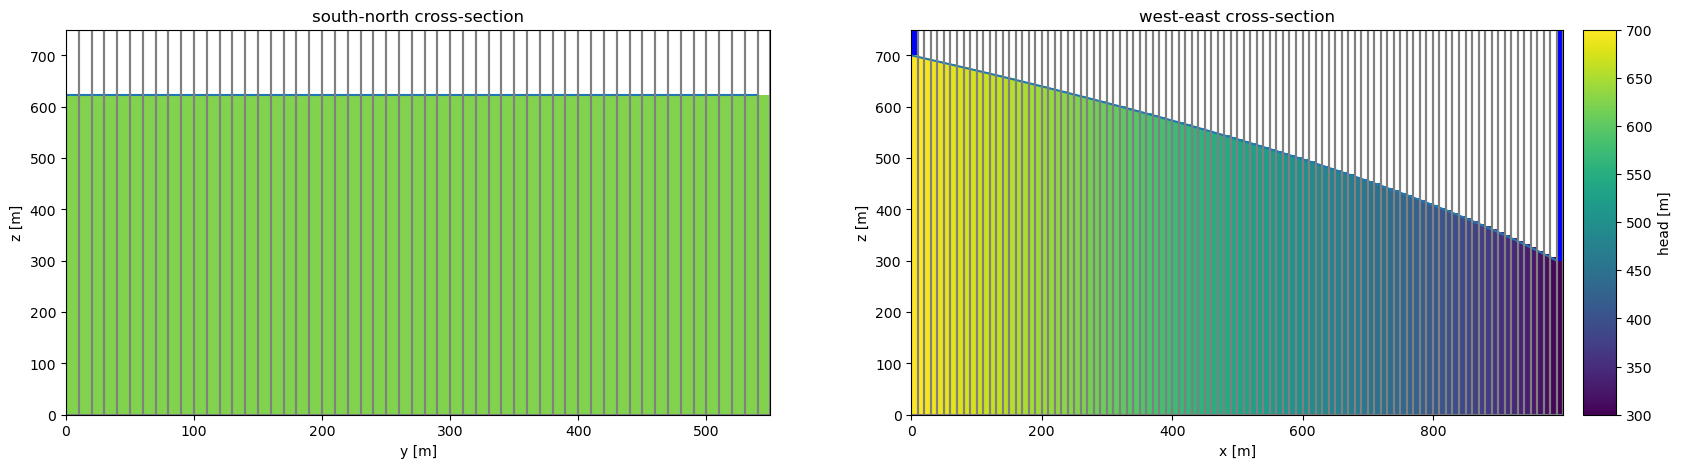

In [24]:
if vartest == True:

    ##Get outputs:
    #This section usually does not change much
    
    #Get MODFLOW outputs:
    hds = bf.HeadFile(modelname+'.hds')    #reads the raw binary head output file 
    times = hds.get_times()                #returns a list of timesteps
    head = hds.get_data(totim=times[-1])   #returns an array of heads for the specified time (last timestep)
    head_mx = ma.masked_values (head, -999.99)  #make a masked head array where all no-flow cells (with the value -999.99) are hidden
    
    #Get cell-by-cell outputs from the cell budget output file:
    #string options are in the list file under output control (make sure to include spaces!)
    cbb = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
    kstpkper_list = cbb.get_kstpkper()          #returns a list of stress periods & timesteps
    frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]      #returns an array of flow rates for right face of cells
    fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]      #returns an array of flow rates for front face of cells
        
    vmin = head_mx.min()                      #find the lowest head in entire model (excluding no-flow cells)
    vmax = head_mx.max()      
    
    f,ax = plt.subplots(1,2, figsize=(20,5))                                     #create empty figure and axes objects
    xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[0], line={'Column': 25})  #plot cross-section along given column (change column # to see different locations)
    bc = xsec.plot_ibound()                                                      #plot boundary conditions
    h  = xsec.plot_array(head, masked_values=[-999.99], head=head, vmin=vmin, vmax=vmax)  #plot heads as an array, with color range set by min and max of full array
    ax[0].plot(np.arange(0,Ly,delr), head_mx[0,:,25])                            #plots heads as a line
    g  = xsec.plot_grid()                                                        #plot model grid
    ax[0].set_xlabel('y [m]')
    ax[0].set_ylabel('z [m]')
    ax[0].set_title('south-north cross-section')
    
    xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[1], line={'Row': 25})      #plot cross-ection along given row
    bc = xsec.plot_ibound()                                                      #plot boundary conditions
    h  = xsec.plot_array(head, masked_values=[-999.99], head=head, vmin=vmin, vmax=vmax)   #plot heads as array with same color range as above
    ax[1].plot(np.arange(0,Lx,delc), head_mx[0,25,:])                            #plots heads as a line
    g  = xsec.plot_grid()                                                        #plot grid
    ax[1].set_xlabel('x [m]')
    ax[1].set_ylabel('z [m]')
    ax[1].set_title('west-east cross-section')
    
    #Add colorbar:
    divider = make_axes_locatable(ax[1])                     #make axes dividable (to add colorbar)
    cax = divider.append_axes('right', size="5%", pad=0.2)   #add an axis at the bottom for the colorbar
    c = plt.colorbar(h, cax=cax, orientation='vertical')     #plot the colorbar
    c.set_label('head [m]')

In [25]:
if vartest == True:
    H_init = 690.                                #initial hydraulic head in meters
    strt = np.full((n_lays, n_rows, n_cols), H_init)  #float (i.e. decimal) array, sets initial head in all cells to desired value
    strt[:,:,0] = 700
    strt[:,:,n_cols-1] = 200
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt) 
    mf.write_input()
    success, buff = mf.run_model()

FloPy is using the following  executable to run the model: .\CFPv2.EXE

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                   Version 1.9.62 2019/09/16 CFPv2 HTM/STM/UMT-LNK/CADS
THIS IS A RESEARCH VERSION OF CFP MODE 1 FOR TEST PURPOSES WITHOUT ANY WARRANTY REGARDING CORRECTNESS
CONTACT: THOMAS.REIMANN@TU-DRESDEN.DE AND BSHOEMAK@USGS.GOV

 Using NAME file: base.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/03/08 13:04:31

 CFP FLOW STRESS PERIOD:     1 TIME STEP:     1
 RUN END DATE AND TIME (YYYY/MM/DD HH:MM:SS): 2024/03/08 13:04:31
 ELAPSED RUN TIME:  0.198 SECONDS

  NORMAL TERMINATION OF SIMULATION


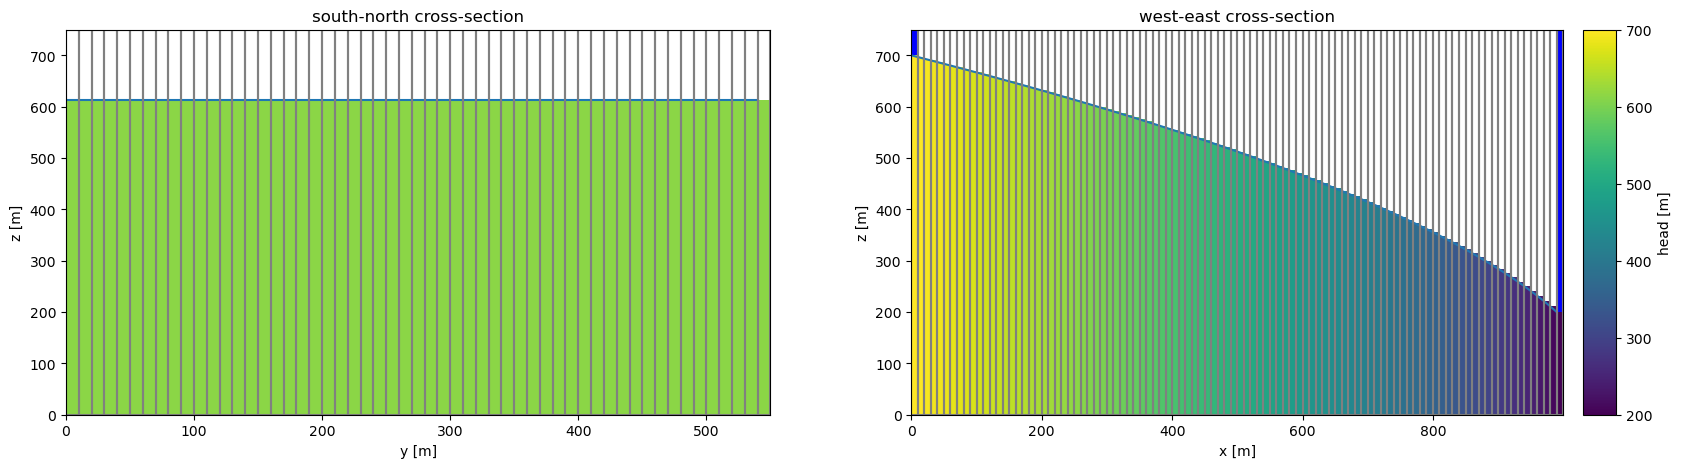

In [26]:
if vartest == True:

    ##Get outputs:
    #This section usually does not change much
    
    #Get MODFLOW outputs:
    hds = bf.HeadFile(modelname+'.hds')    #reads the raw binary head output file 
    times = hds.get_times()                #returns a list of timesteps
    head = hds.get_data(totim=times[-1])   #returns an array of heads for the specified time (last timestep)
    head_mx = ma.masked_values (head, -999.99)  #make a masked head array where all no-flow cells (with the value -999.99) are hidden
    
    #Get cell-by-cell outputs from the cell budget output file:
    #string options are in the list file under output control (make sure to include spaces!)
    cbb = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
    kstpkper_list = cbb.get_kstpkper()          #returns a list of stress periods & timesteps
    frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]      #returns an array of flow rates for right face of cells
    fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]      #returns an array of flow rates for front face of cells
        
    vmin = head_mx.min()                      #find the lowest head in entire model (excluding no-flow cells)
    vmax = head_mx.max()      
    
    f,ax = plt.subplots(1,2, figsize=(20,5))                                     #create empty figure and axes objects
    xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[0], line={'Column': 25})  #plot cross-section along given column (change column # to see different locations)
    bc = xsec.plot_ibound()                                                      #plot boundary conditions
    h  = xsec.plot_array(head, masked_values=[-999.99], head=head, vmin=vmin, vmax=vmax)  #plot heads as an array, with color range set by min and max of full array
    ax[0].plot(np.arange(0,Ly,delr), head_mx[0,:,25])                            #plots heads as a line
    g  = xsec.plot_grid()                                                        #plot model grid
    ax[0].set_xlabel('y [m]')
    ax[0].set_ylabel('z [m]')
    ax[0].set_title('south-north cross-section')
    
    xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[1], line={'Row': 25})      #plot cross-ection along given row
    bc = xsec.plot_ibound()                                                      #plot boundary conditions
    h  = xsec.plot_array(head, masked_values=[-999.99], head=head, vmin=vmin, vmax=vmax)   #plot heads as array with same color range as above
    ax[1].plot(np.arange(0,Lx,delc), head_mx[0,25,:])                            #plots heads as a line
    g  = xsec.plot_grid()                                                        #plot grid
    ax[1].set_xlabel('x [m]')
    ax[1].set_ylabel('z [m]')
    ax[1].set_title('west-east cross-section')
    
    #Add colorbar:
    divider = make_axes_locatable(ax[1])                     #make axes dividable (to add colorbar)
    cax = divider.append_axes('right', size="5%", pad=0.2)   #add an axis at the bottom for the colorbar
    c = plt.colorbar(h, cax=cax, orientation='vertical')     #plot the colorbar
    c.set_label('head [m]')

In [27]:
if vartest == True:
    H_init = 690.                                #initial hydraulic head in meters
    strt = np.full((n_lays, n_rows, n_cols), H_init)  #float (i.e. decimal) array, sets initial head in all cells to desired value
    strt[:,:,0] = 700
    strt[:,:,n_cols-1] = 100
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt) 
    mf.write_input()
    success, buff = mf.run_model()

FloPy is using the following  executable to run the model: .\CFPv2.EXE

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                   Version 1.9.62 2019/09/16 CFPv2 HTM/STM/UMT-LNK/CADS
THIS IS A RESEARCH VERSION OF CFP MODE 1 FOR TEST PURPOSES WITHOUT ANY WARRANTY REGARDING CORRECTNESS
CONTACT: THOMAS.REIMANN@TU-DRESDEN.DE AND BSHOEMAK@USGS.GOV

 Using NAME file: base.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/03/08 13:04:31

 CFP FLOW STRESS PERIOD:     1 TIME STEP:     1
 RUN END DATE AND TIME (YYYY/MM/DD HH:MM:SS): 2024/03/08 13:04:32
 ELAPSED RUN TIME:  0.208 SECONDS

  NORMAL TERMINATION OF SIMULATION


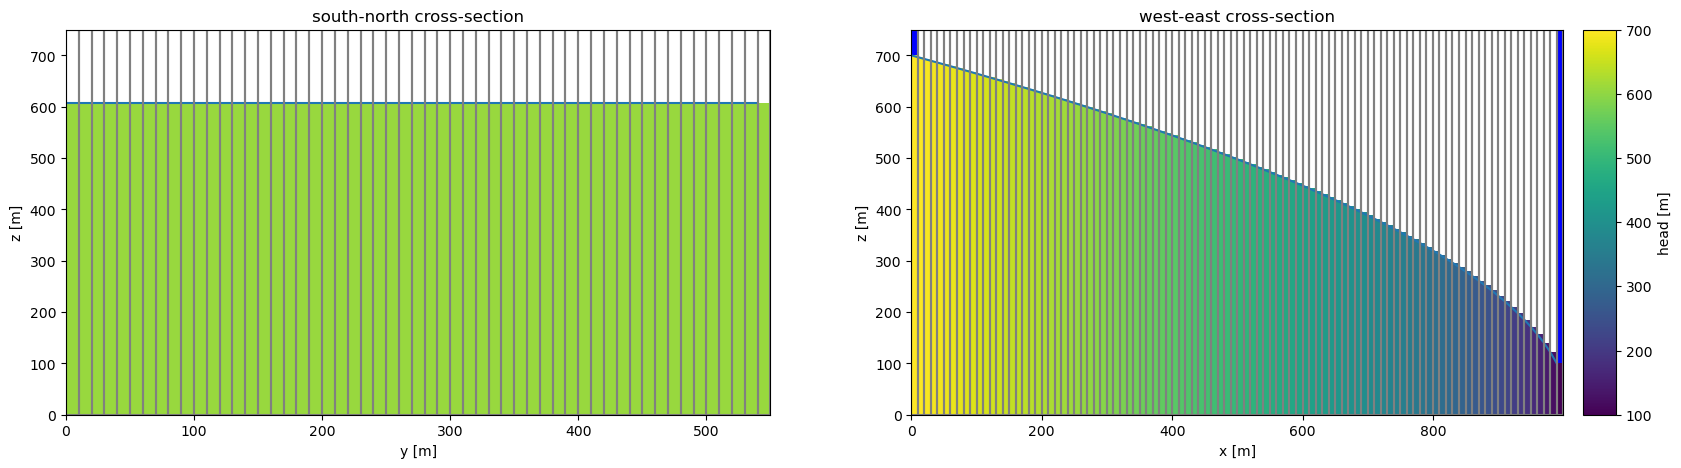

In [28]:
if vartest == True:

    ##Get outputs:
    #This section usually does not change much
    
    #Get MODFLOW outputs:
    hds = bf.HeadFile(modelname+'.hds')    #reads the raw binary head output file 
    times = hds.get_times()                #returns a list of timesteps
    head = hds.get_data(totim=times[-1])   #returns an array of heads for the specified time (last timestep)
    head_mx = ma.masked_values (head, -999.99)  #make a masked head array where all no-flow cells (with the value -999.99) are hidden
    
    #Get cell-by-cell outputs from the cell budget output file:
    #string options are in the list file under output control (make sure to include spaces!)
    cbb = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
    kstpkper_list = cbb.get_kstpkper()          #returns a list of stress periods & timesteps
    frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]      #returns an array of flow rates for right face of cells
    fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]      #returns an array of flow rates for front face of cells
        
    vmin = head_mx.min()                      #find the lowest head in entire model (excluding no-flow cells)
    vmax = head_mx.max()      
    
    f,ax = plt.subplots(1,2, figsize=(20,5))                                     #create empty figure and axes objects
    xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[0], line={'Column': 25})  #plot cross-section along given column (change column # to see different locations)
    bc = xsec.plot_ibound()                                                      #plot boundary conditions
    h  = xsec.plot_array(head, masked_values=[-999.99], head=head, vmin=vmin, vmax=vmax)  #plot heads as an array, with color range set by min and max of full array
    ax[0].plot(np.arange(0,Ly,delr), head_mx[0,:,25])                            #plots heads as a line
    g  = xsec.plot_grid()                                                        #plot model grid
    ax[0].set_xlabel('y [m]')
    ax[0].set_ylabel('z [m]')
    ax[0].set_title('south-north cross-section')
    
    xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[1], line={'Row': 25})      #plot cross-ection along given row
    bc = xsec.plot_ibound()                                                      #plot boundary conditions
    h  = xsec.plot_array(head, masked_values=[-999.99], head=head, vmin=vmin, vmax=vmax)   #plot heads as array with same color range as above
    ax[1].plot(np.arange(0,Lx,delc), head_mx[0,25,:])                            #plots heads as a line
    g  = xsec.plot_grid()                                                        #plot grid
    ax[1].set_xlabel('x [m]')
    ax[1].set_ylabel('z [m]')
    ax[1].set_title('west-east cross-section')
    
    #Add colorbar:
    divider = make_axes_locatable(ax[1])                     #make axes dividable (to add colorbar)
    cax = divider.append_axes('right', size="5%", pad=0.2)   #add an axis at the bottom for the colorbar
    c = plt.colorbar(h, cax=cax, orientation='vertical')     #plot the colorbar
    c.set_label('head [m]')

In [29]:
if vartest == True:
    H_init = 400.                                #initial hydraulic head in meters
    strt = np.full((n_lays, n_rows, n_cols), H_init)  #float (i.e. decimal) array, sets initial head in all cells to desired value
    strt[:,:,0] = 700
    strt[:,:,n_cols-1] = 1
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt) 
    mf.write_input()
    success, buff = mf.run_model()

FloPy is using the following  executable to run the model: .\CFPv2.EXE

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                   Version 1.9.62 2019/09/16 CFPv2 HTM/STM/UMT-LNK/CADS
THIS IS A RESEARCH VERSION OF CFP MODE 1 FOR TEST PURPOSES WITHOUT ANY WARRANTY REGARDING CORRECTNESS
CONTACT: THOMAS.REIMANN@TU-DRESDEN.DE AND BSHOEMAK@USGS.GOV

 Using NAME file: base.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/03/08 13:04:32

 CFP FLOW STRESS PERIOD:     1 TIME STEP:     1
 RUN END DATE AND TIME (YYYY/MM/DD HH:MM:SS): 2024/03/08 13:04:32
 ELAPSED RUN TIME:  0.183 SECONDS

  NORMAL TERMINATION OF SIMULATION


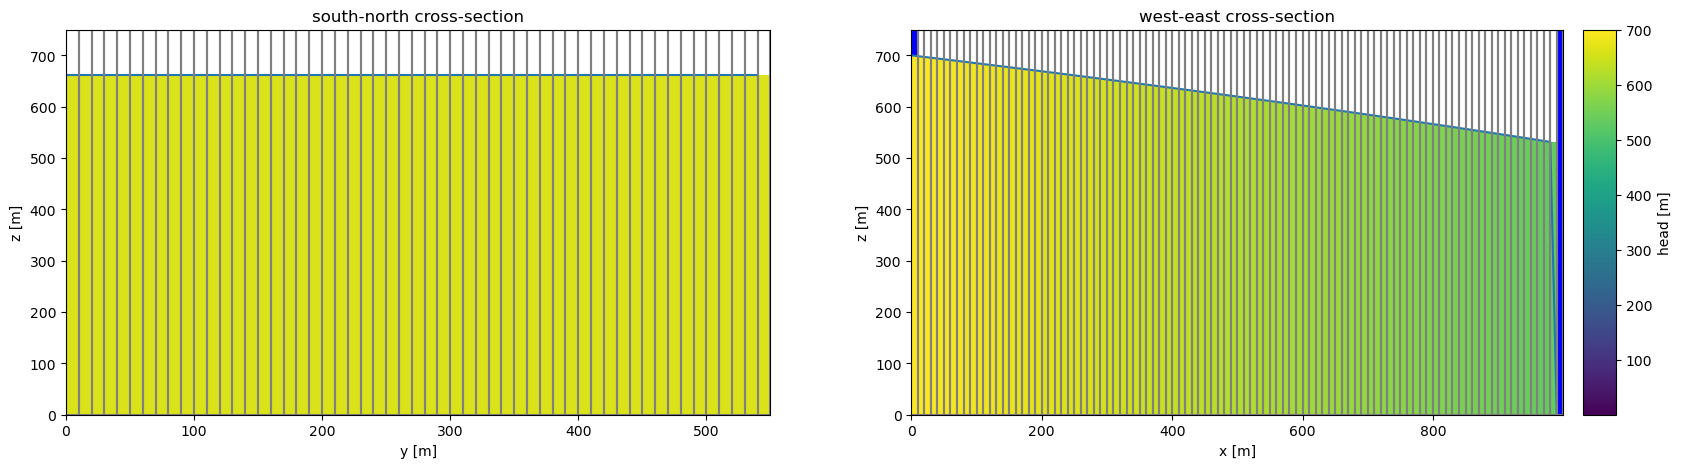

In [30]:
if vartest == True:

    ##Get outputs:
    #This section usually does not change much
    
    #Get MODFLOW outputs:
    hds = bf.HeadFile(modelname+'.hds')    #reads the raw binary head output file 
    times = hds.get_times()                #returns a list of timesteps
    head = hds.get_data(totim=times[-1])   #returns an array of heads for the specified time (last timestep)
    head_mx = ma.masked_values (head, -999.99)  #make a masked head array where all no-flow cells (with the value -999.99) are hidden
    
    #Get cell-by-cell outputs from the cell budget output file:
    #string options are in the list file under output control (make sure to include spaces!)
    cbb = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
    kstpkper_list = cbb.get_kstpkper()          #returns a list of stress periods & timesteps
    frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]      #returns an array of flow rates for right face of cells
    fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]      #returns an array of flow rates for front face of cells
        
    vmin = head_mx.min()                      #find the lowest head in entire model (excluding no-flow cells)
    vmax = head_mx.max()      
    
    f,ax = plt.subplots(1,2, figsize=(20,5))                                     #create empty figure and axes objects
    xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[0], line={'Column': 25})  #plot cross-section along given column (change column # to see different locations)
    bc = xsec.plot_ibound()                                                      #plot boundary conditions
    h  = xsec.plot_array(head, masked_values=[-999.99], head=head, vmin=vmin, vmax=vmax)  #plot heads as an array, with color range set by min and max of full array
    ax[0].plot(np.arange(0,Ly,delr), head_mx[0,:,25])                            #plots heads as a line
    g  = xsec.plot_grid()                                                        #plot model grid
    ax[0].set_xlabel('y [m]')
    ax[0].set_ylabel('z [m]')
    ax[0].set_title('south-north cross-section')
    
    xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[1], line={'Row': 25})      #plot cross-ection along given row
    bc = xsec.plot_ibound()                                                      #plot boundary conditions
    h  = xsec.plot_array(head, masked_values=[-999.99], head=head, vmin=vmin, vmax=vmax)   #plot heads as array with same color range as above
    ax[1].plot(np.arange(0,Lx,delc), head_mx[0,25,:])                            #plots heads as a line
    g  = xsec.plot_grid()                                                        #plot grid
    ax[1].set_xlabel('x [m]')
    ax[1].set_ylabel('z [m]')
    ax[1].set_title('west-east cross-section')
    
    #Add colorbar:
    divider = make_axes_locatable(ax[1])                     #make axes dividable (to add colorbar)
    cax = divider.append_axes('right', size="5%", pad=0.2)   #add an axis at the bottom for the colorbar
    c = plt.colorbar(h, cax=cax, orientation='vertical')     #plot the colorbar
    c.set_label('head [m]')